In [82]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import galsim
from IPython.display import clear_output
from astropy.io import fits
from matplotlib.colors import LogNorm
from numpy import mgrid, sum
import scipy.linalg as alg
import scipy.stats as stats
from galsim.zernike import Zernike
import matplotlib
import pickle
from scipy import interpolate


In [2]:
import time

In [3]:
import sys
sys.path.append('/Users/zhangtianqing/Documents/Research/PSF_Rachel/HOMESim')
import homesm
import metasm

In [208]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
sns.color_palette("Set2")
cmap = sns.color_palette("colorblind")


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.pyplot as plt

plt.gcf().subplots_adjust(bottom=0.15)

<Figure size 600x400 with 0 Axes>

In [4]:
class shapeletXmoment:
    
    def __init__(self, psf,n, bmax = 10, pixel_scale = 1.0):
        self.n = n
        self.bmax = bmax
        self.pixel_scale = pixel_scale
        self.base_psf = psf
        self.base_psf_image = psf.drawImage(scale = pixel_scale)
        self.base_psf_result = galsim.hsm.FindAdaptiveMom(self.base_psf_image)
        self.base_shapelet = galsim.Shapelet.fit(self.base_psf_result.moments_sigma, bmax, self.base_psf_image, normalization = 'sb')
        self.base_bvec = self.base_shapelet.bvec
        
    def moment_measure(self, image, p, q):
        n = p+q
        
        if n<2:
            print( "Does not support moment measure less than second order.")
            return 0
        elif n==2:
            return self.get_second_moment(image,p,q)
        else:
            return self.higher_weighted_moment(image,p,q)
        
    def get_second_moment(self, image, p ,q):
        image_results = galsim.hsm.FindAdaptiveMom(image)
        if p==2:
            return image_results.observed_shape.e1
        elif q==2:
            return image_results.observed_shape.e2
        else:
            return image_results.moments_sigma
        
    def higher_weighted_moment(self,gsimage,p,q):
        
        image = gsimage.array
        

        y, x = mgrid[:image.shape[0],:image.shape[1]]+1

        psfresults = galsim.hsm.FindAdaptiveMom(galsim.Image(image, scale = self.pixel_scale))
        M = np.zeros((2,2))
        e1 = psfresults.observed_shape.e1
        e2 = psfresults.observed_shape.e2
        sigma4 = psfresults.moments_sigma**4
        c = (1+e1)/(1-e1)
        M[1][1] = np.sqrt(sigma4/(c-0.25*e2**2*(1+c)**2))
        M[0][0] = c*M[1][1]
        M[0][1] = 0.5*e2*(M[1][1]+M[0][0])
        M[1][0] = M[0][1]

        pos = np.array([x-psfresults.moments_centroid.x, y-psfresults.moments_centroid.y])
        pos = np.swapaxes(pos,0,1)
        pos = np.swapaxes(pos,1,2)


        inv_M = np.linalg.inv(M)
        sqrt_inv_M = alg.sqrtm(inv_M)
        std_pos = np.zeros(pos.shape)
        weight = np.zeros(pos.shape[0:2])
        for i in range(pos.shape[0]):
            for j in range(pos.shape[1]):
                this_pos = pos[i][j]
                this_standard_pos = np.matmul(sqrt_inv_M, this_pos)
                std_pos[i][j] = this_standard_pos
                weight[i][j] = np.exp(-0.5* this_standard_pos.dot(this_standard_pos))

        std_x, std_y = std_pos[:,:,0],std_pos[:,:,1]

        return sum(std_x**p*std_y**q*weight*image)/sum(image*weight)
    
    
    def modify_pq(self, m, c, delta = 0.0001):
        
        n = self.n
        mu = self.get_mu(n)
        pq_list = self.get_pq_full(n)
        shapelet_list = self.pq2shapelet(pq_list)

        ori_moments = self.get_all_moments(self.base_psf_image, pq_list)
        
        A = np.zeros(shape =(mu, mu))
        
        #i is the mode index
        #j is the moment index
        #measure d_moment_j / d_mode_i
        
        for i in range(mu):
            
            mode_index = shapelet_list[i]
            
            pert_bvec = self.base_bvec.copy()
            pert_bvec[mode_index]+=delta
            ith_pert = galsim.Shapelet(self.base_psf_result.moments_sigma, self.bmax, pert_bvec)
            pert_moment = self.get_all_moments(ith_pert.drawImage(scale = self.pixel_scale,method = 'no_pixel'), pq_list)
            for j in range(mu):
                A[i][j] = (pert_moment[j] - ori_moments[j])/delta     
        self.A = A


        dm = np.zeros(mu)
        dm += m*ori_moments + c
        ds = np.linalg.solve(A.T,dm)
        #print ds
        #print dm
        
        true_mod_bvec = self.base_bvec.copy()
        for i in range(mu):
            true_mod_bvec[shapelet_list[i]]+=ds[i]

        
        self.true_mod = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, true_mod_bvec)
        return self.true_mod
    
    def step_modify_pq(self,current_moments,current_dm, current_mod_bvec ,current_psf,mu,shapelet_list,delta, pq_list):
        
        A = np.zeros(shape =(mu, mu))

        
        for i in range(mu):
            mode_index = shapelet_list[i]
            
            pert_bvec = current_mod_bvec.copy()
            pert_bvec[mode_index]+=delta
            ith_pert = galsim.Shapelet(self.base_psf_result.moments_sigma, self.bmax, pert_bvec)
            pert_moment = self.get_all_moments(ith_pert.drawImage(scale = self.pixel_scale), pq_list)
            for j in range(mu):
                A[i][j] = (pert_moment[j] - current_moments[j])/delta     


        ds = np.linalg.solve(A.T,current_dm)
        
        for i in range(mu):
            current_mod_bvec[shapelet_list[i]]+=ds[i]
        return current_mod_bvec
            
    def iterative_modify_pq(self,m,c,delta = 0.0001, threshold = 1e-6):
        
        iterative_n = 10
        
        n = self.n
        mu = self.get_mu(n)
        pq_list = self.get_pq_full(n)
        shapelet_list = self.pq2shapelet(pq_list)
        base_shapelet_image = self.base_shapelet.drawImage(scale = self.pixel_scale)
        original_moment = self.get_all_moments(base_shapelet_image, pq_list)
        current_moment = self.get_all_moments(base_shapelet_image, pq_list)
        
        current_dm = np.zeros(mu)
        current_dm += m*current_moment + c
        
        destiny_moment = current_moment + current_dm
        
        current_mod_bvec = self.base_bvec.copy()
        current_psf = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, current_mod_bvec)
        
        while (np.max(np.abs(current_dm)) > threshold):
            
            current_mod_bvec = self.step_modify_pq(current_moment,current_dm, current_mod_bvec ,current_psf,mu,shapelet_list,delta,pq_list)
            current_psf = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, current_mod_bvec)
            current_moment = self.get_all_moments(current_psf.drawImage(scale = self.pixel_scale), pq_list)
            
            current_dm = destiny_moment - current_moment
            #print current_dm
            #print current_moment - original_moment
        return current_psf
                
    def get_all_moments(self, image, pq_list):
        results_list = []
        for tup in pq_list:
            results_list.append(self.moment_measure(image, tup[0], tup[1]))
                
        return np.array(results_list)
        
        
    def pq2mode(self,p,q):
        
        if p<=q:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)
        else:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)+1
        
        
        
    def pq2shapelet(self,pq_list):
        shapelet_index = []
        for tup in pq_list:
            shapelet_index.append(self.pq2mode(tup[0], tup[1]))
        return shapelet_index
        
        
        

        
        
    def get_mu(self, n):
        
        mu = 0
        for i in range(2,n+1):
            mu+=i+1
        return mu
    
    def get_pq_full(self,nmax):
        
        pq_list = []
        
        for n in range(2, nmax+1):
            p = 0
            q = n
            
            pq_list.append((p,q))
            
            while p<n:
                p+=1
                q-=1
                pq_list.append((p,q))
        return pq_list
    
    def get_pq_except(self,nmax,p,q):
        
        pq_full = self.get_pq_full(nmax)
        pq_except = []
        for tup in pq_full:
            if tup != (p,q):
                pq_except.append(tup)
                
        return pq_except
     
        

In [5]:


class HOMExShapeletPair:
    
    def __init__(self, gal_type, gal_sigma,e1,e2,g1,g2,psf_type,psf_sigma,
                gal_flux=1.e2,pixel_scale = 1.0,sersicn = -1,subtract_intersection = True,
                is_self_defined_PSF = False , self_defined_PSF=None, self_define_PSF_model = None,metacal_method = 'estimateShear', GREAT3 = False, 
                cosmic_shear = None, great3_ind = None, great3_cat = None, bpd_params = None):
        
        #Define basic variables
        self.pixel_scale = pixel_scale        
        self.subtract_intersection = subtract_intersection        
        self.is_self_defined_PSF = is_self_defined_PSF
        self.metacal_method = metacal_method

        
        #Define galaxy
        self.gal_type = gal_type
        self.gal_sigma = gal_sigma
        self.gal_flux=gal_flux
        self.e1 = e1
        self.e2 = e2
        self.g1 = g1
        self.g2 = g2
        self.cosmic_shear = galsim.Shear(g1 = g1, g2 = g2)
        self.g = np.array([g1,g2])
        self.e = np.array([e1,e2])
        self.sersicn=sersicn
        self.e_truth = self.e
        
        self.bpd_params = bpd_params

#         if gal_type == "gaussian":
#             self.gal_light = galsim.Gaussian(flux = self.gal_flux, sigma = Gaussian_sigma(self.gal_sigma,self.pixel_scale))
#         elif gal_type == "sersic":
#             self.gal_light = self.findAdaptiveSersic(gal_sigma,sersicn)
        if gal_type == 'gaussian':
            gaussian_profile = galsim.Gaussian(sigma = gal_sigma)
            #gaussian_profile = self.toSize(gaussian_profile, self.gal_sigma,weighted = True)
            self.gal_light = gaussian_profile.withFlux(self.gal_flux)
            self.gal_light = self.gal_light.shear(e1=e1, e2=e2)
        elif gal_type == 'sersic':
            sersic_profile = galsim.Sersic(sersicn, half_light_radius = self.gal_sigma)
            #sersic_profile = self.toSize(sersic_profile, self.gal_sigma,weighted = True)
            self.gal_light = sersic_profile.withFlux(self.gal_flux)
            self.gal_light = self.gal_light.shear(e1=e1, e2=e2)

        elif gal_type == 'bpd':
            bulge = galsim.Sersic(4, half_light_radius = self.bpd_params[0])
            bulge = bulge.shear(e1 = bpd_params[1], e2 = bpd_params[2])
            disk = galsim.Sersic(1, half_light_radius = self.bpd_params[3])
            disk = disk.shear(e1 = bpd_params[4], e2 = bpd_params[5])
            bulge_to_total = bpd_params[6]
            self.gal_light = bulge_to_total*bulge + (1-bulge_to_total)*disk
            
            self.gal_light = self.gal_light.withFlux(self.gal_flux)

        self.gal_rotate_light = self.gal_light.rotate(90 * galsim.degrees)
        self.gal_light = self.gal_light.shear(g1 = g1, g2 = g2)
        self.gal_rotate_light = self.gal_rotate_light.shear(g1 = g1, g2 = g2)
        
        if not is_self_defined_PSF:
            self.psf_type = psf_type
            self.psf_sigma = psf_sigma
            self.psf_model_sigma = psf_sigma

          
            if psf_type == 'gaussian':
                self.psf_base = galsim.Gaussian(flux = 1.0, sigma = self.psf_sigma)
                #self.psf_base = self.toSize(self.psf_base, self.psf_sigma)
            elif psf_type == 'kolmogorov':
                self.psf_base  = galsim.Kolmogorov(flux = 1.0, half_light_radius = self.psf_sigma)
                #self.psf_base = self.toSize(self.psf_base, self.psf_sigma,weighted = True)
            elif psf_type == 'opticalPSF':
                self.psf_base = galsim.OpticalPSF(1.0,flux = 1.0)
                self.psf_base = self.toSize(self.psf_base, self.psf_sigma)
            elif psf_type == 'sersic':
                self.psf_base = galsim.Sersic(psf_sersicn, half_light_radius = 1.0)
                self.psf_base = self.toSize(self.psf_base, self.psf_sigma,weighted = True)
  
        else:
            self.psf_type = "self_define"
            truth_image = self_defined_PSF
            truth_psf = galsim.InterpolatedImage(truth_image,scale = pixel_scale)
            truth_measure = galsim.hsm.FindAdaptiveMom(truth_image)
            truth_sigma = truth_measure.moments_sigma
            self.psf_light = truth_psf
            
    def setup_shapelet_psf(self, m, c, n, bmax = 10):
        self.n = n
        self.sxm = shapeletXmoment(self.psf_base,n,pixel_scale = self.pixel_scale)
        self.psf_light = self.sxm.base_shapelet
        self.psf_model_light = self.sxm.iterative_modify_pq(m, c)
        self.dm = m*self.sxm.get_all_moments(self.sxm.base_psf_image, self.sxm.get_pq_full(n))+c


    def speed_setup_shapelet_psf(self,m,c,n, psf_light, psf_model_light, dm):
        self.n = n
        self.sxm = shapeletXmoment(self.psf_base,n,pixel_scale = self.pixel_scale)
        self.psf_light = psf_light
        self.psf_model_light = psf_model_light
        self.dm = dm
    
    
    def perc_bias(self,metacal = True):
        
        base_ori_r, base_ori_e = self.measure(metacal = metacal,rot = False, base = True)
        mod_ori_r, mod_ori_e = self.measure(metacal = metacal,rot = False, base = False)
        base_rot_r, base_rot_e = self.measure(metacal = metacal,rot = True, base = True)
        mod_rot_r, mod_rot_e = self.measure(metacal = metacal,rot = True, base = False)
                
        
        R_base = np.mean(np.array([base_ori_r,base_rot_r]),axis = 0).reshape(2,2)
        base_shape = np.mean(np.array([base_ori_e,base_rot_e]),axis = 0)
        g_base = np.matmul(np.linalg.inv(R_base),base_shape)
        
        R_mod = np.mean(np.array([mod_ori_r,mod_rot_r]),axis = 0).reshape(2,2)
        mod_shape = np.mean(np.array([mod_ori_e,mod_rot_e]),axis = 0)
        g_mod = np.matmul(np.linalg.inv(R_mod),mod_shape)
        #print (g_mod[0] - g_base[0])/self.g1
        self.abs_bias = (g_mod - g_base)
        return (g_mod - g_base)/self.g
        
    def measure(self,metacal=True,rot = False, base = False):
        if base:
            image_epsf = self.psf_light.drawImage(scale=self.pixel_scale)
        else:
            image_epsf = self.psf_model_light.drawImage(scale=self.pixel_scale)
            
        if rot:
            galaxy = self.gal_rotate_light
        else:
            galaxy = self.gal_light
        
        final = galsim.Convolve([galaxy,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        if metacal == False:
            results = galsim.hsm.EstimateShear(image,image_epsf)
            shape = galsim.Shear(e1 = results.corrected_e1, e2 = results.corrected_e2)
            return np.array([[1.0,0,0,1.0]]),np.array([shape.g1,shape.g2])
        else:
            results = self.perform_metacal(image,image_epsf)
            return results["R"].reshape((-1)), results["noshear"]
        
    def perform_metacal(self,image,image_epsf):
        metacal = metasm.metacal_shear_measure(image,image_epsf,great3 = True)
        metacal.measure_shear(self.metacal_method)
        results = metacal.get_results()
        return results
    
    def findAdaptiveSersic(self,sigma,n):
        good_half_light_re = bisect(Sersic_sigma,sigma/3,sigma*5,args=(n,self.pixel_scale,sigma))
        return galsim.Sersic(n=n,half_light_radius=good_half_light_re)
    
    def findAdaptiveKolmogorov(self,sigma):
        good_half_light_re = bisect(Kolmogorov_sigma,max(self.psf_sigma/5,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.Kolmogorov(half_light_radius = good_half_light_re)
    
    def findAdaptiveOpticalPSF(self,sigma):
        good_fwhm = bisect(OpticalPSF_sigma,max(self.psf_sigma/3,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.OpticalPSF(good_fwhm)
    
    def toSize(self, profile, sigma , weighted = True, tol = 1e-4):


        if weighted:
            apply_pixel =  max(self.pixel_scale, sigma/10)
            true_sigma = galsim.hsm.FindAdaptiveMom(profile.drawImage(scale =apply_pixel,method = 'no_pixel')).moments_sigma*apply_pixel
        else:
            #true_sigma = profile.calculateMomentRadius(scale = self.pixel_scale, rtype='trace')

            
            image = profile.drawImage(scale = self.pixel_scale, method = 'no_pixel')
            true_sigma = image.calculateMomentRadius()

        ratio = sigma/true_sigma
        new_profile = profile.expand(ratio)

        while abs(true_sigma - sigma)>tol:
            ratio = sigma/true_sigma
            new_profile = new_profile.expand(ratio)

            if weighted:
                
                apply_pixel =  max(self.pixel_scale, sigma/10)
                true_sigma = galsim.hsm.FindAdaptiveMom(new_profile.drawImage(scale =apply_pixel,method = 'no_pixel'),hsmparams=galsim.hsm.HSMParams(max_mom2_iter = 2000)).moments_sigma*apply_pixel
            else:
                #true_sigma = profile.calculateMomentRadius(scale = self.pixel_scale, rtype='trace')
                image = new_profile.drawImage(scale = self.pixel_scale, method = 'no_pixel')
                true_sigma = image.calculateMomentRadius()
        return new_profile
        
    
    def real_gal_sigma(self):
        image = self.gal_light.drawImage(scale = self.pixel_scale,method = 'no_pixel')
        return galsim.hsm.FindAdaptiveMom(image).moments_sigma*self.pixel_scale
    
    def get_actual_dm(self):
        m_truth = self.sxm.get_all_moments(self.psf_light.drawImage(scale=self.pixel_scale), self.sxm.get_pq_full(self.n))
        m_model = self.sxm.get_all_moments(self.psf_model_light.drawImage(scale=self.pixel_scale), self.sxm.get_pq_full(self.n))
        
        return m_model - m_truth
    
    def get_results(self,metacal = True):
        results = dict()
        
        
        results['shear_bias'] = self.perc_bias(metacal = metacal)
        results['abs_bias'] = self.abs_bias
        results["gal_type"] = self.gal_type
        results["psf_type"] = self.psf_type
        
        
        
        #results["gal_sigma"] = self.gal_sigma
        #results["psf_sigma"] = self.psf_sigma
        
        results["bpd_params"] = self.bpd_params
        
        results["e1"] = self.e1
        results["e2"] = self.e2
        results["e"] = self.e
        results["sersicn"] = self.sersicn
        
        
        
        #results["gal_hlr"] = self.gal_light.calculateHLR()
        results["psf_hlr"] = self.psf_sigma
        results["psf_model_sigma"] = self.psf_model_sigma
        results['g'] = self.g
        results["dm"] = self.dm
        
        #results["actual_dm"] = self.get_actual_dm()
        
        

        
        return results
    
    
    

In [6]:
test0 = HOMExShapeletPair("gaussian", 3.0, 0.2, 0.2, 0.01, 0.01, "gaussian", 2.0)
m = np.zeros(12)
c = np.zeros(12)
c[9]+=0.001
test0.setup_shapelet_psf(m,c,4)
pqlist = test0.sxm.get_pq_full(6)[3:]


In [10]:
bpd_parameters_dict = dict()

In [11]:
pixel_size  = 0.2
for i, bulge_size in enumerate(np.arange(0.1,1.1,0.1)/pixel_size):
    for j, disk_size in enumerate(np.arange(0.2,2.2,0.2)/pixel_size):
        for k,ratio in enumerate(np.arange(0.0, 1.2, 0.2)):
            
            bpd_parameters_dict[(i,j,k)] = (bulge_size, 0.0, 0.0, disk_size, 0.1, 0.2, ratio)
            

In [139]:
def do_tests_speed(tests,test_m, test_c,n):
    testsresult=[]
    for i in range(len(tests)):
        
        
        test = HOMExShapeletPair(*tests[i][:-1],**tests[i][-1])
        if i!=0:
            test.speed_setup_shapelet_psf(test_m,test_c,n,psf_light, psf_model_light, dm)
        else:
            test.setup_shapelet_psf(test_m,test_c,n)
            
            
            psf_light = test.psf_light
            psf_model_light = test.psf_model_light
            dm = test.dm
            
        results = test.get_results(metacal = False)
        
        
        testsresult.append(results)
        clear_output() 
        print ("Finished "+str(float((i+1))/len(tests)*100)+"%")
    return testsresult
    

In [61]:
test1_results = dict()

In [62]:
print pqlist

[(0, 3), (1, 2), (2, 1), (3, 0), (0, 4), (1, 3), (2, 2), (3, 1), (4, 0), (0, 5), (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]


In [85]:
moment_of_interests = [(4,0),(0,4),(6,0),(4,2),(2,4),(0,6),(3,1),(1,3),(5,1),(3,3),(1,5)]

y1_list = []
y2_list = []
x_list = []
pq4nersc = []


for m in range(22):
    if pqlist[m] in moment_of_interests:
        print pqlist[m]
        pq4nersc.append(pqlist[m])
        
        this_m = np.zeros(shape = (25))
        this_c = np.zeros(shape = (25))
        this_c[m+3] += 0.002
        
        this_test = []
        

        for i, bulge_size in enumerate(np.arange(0.1,1.1,0.1)):
            for j, disk_size in enumerate(np.arange(0.2,2.2,0.2)):
                for k,ratio in enumerate(np.arange(0.0, 1.2, 0.2)):
                    this_test.append(("bpd" ,1.0    ,0.0,0.0,1e-8,1e-8,"kolmogorov"  ,0.305/pixel_size,{'subtract_intersection':True, 'bpd_params':bpd_parameters_dict[(i,j,k)]}))
                    
                    
        m_moment_results = do_tests_speed(this_test,this_m, this_c,6)
        
        dg1 = np.array([t["abs_bias"][0] for t in m_moment_results])/0.002
        dg2 = np.array([t["abs_bias"][1] for t in m_moment_results])/0.002
        
        y1_list.append(dg1)
        y2_list.append(dg2)
        
        
                    
            
        #print(m_moment_results)
                    
                    
                    

Finished (6, 0)100.0%


In [96]:
x = np.array([t["bpd_params"] for t in m_moment_results])
squeeze_x = np.array([x[:,0], x[:,3], x[:,6]]).T

In [98]:
import scipy

In [99]:
y0 = y1_list[0]

In [101]:
print y0.shape

(600,)


In [100]:
print squeeze_x.shape

(600, 3)


In [102]:
func = scipy.interpolate.LinearNDInterpolator(squeeze_x, y0)

In [119]:
func([2.0,10.0,0.0])

array([-0.12366403])

In [120]:
np.save('bpd_results/x.npy',squeeze_x)
np.save('bpd_results/dg1.npy',np.array(y1_list))
np.save('bpd_results/dg2.npy',np.array(y2_list))
np.save('bpd_results/pq4nersc.npy', np.array(pq4nersc))

In [121]:
print(pq4nersc)

[(0, 4), (1, 3), (3, 1), (4, 0), (0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]


In [8]:
e_data = np.load('data/e_data.npy')

In [10]:
print(e_data.shape)

(4, 435)


In [19]:
pixel_size  = 0.2

for i in range(len(e_data)):
    bpd_parameters_dict[i] = (0.2/pixel_size, e_data[i][0] ,e_data[i][1],0.4/pixel_size, e_data[i][2],e_data[i][3], 0.5)
            

In [27]:
moment_of_interests = [(4,0),(0,4),(6,0),(4,2),(2,4),(0,6),(3,1),(1,3),(5,1),(3,3),(1,5)]

y1_list = []
y2_list = []
x_list = []
pq4nersc = []


In [23]:


for m in range(22):
    if pqlist[m] in moment_of_interests:
        print( pqlist[m])
        pq4nersc.append(pqlist[m])
        
        this_m = np.zeros(shape = (25))
        this_c = np.zeros(shape = (25))
        this_c[m+3] += 0.002
        
        this_test = []
        
        for i in range(len(e_data)):
            this_test.append(("bpd" ,1.0    ,0.0,0.0,1e-8,1e-8,"kolmogorov"  ,0.305/pixel_size,{'subtract_intersection':True, 'bpd_params':bpd_parameters_dict[i]}))
        
        m_moment_results = do_tests_speed(this_test,this_m, this_c,6)
        
        dg1 = np.array([t["abs_bias"][0] for t in m_moment_results])/0.002
        dg2 = np.array([t["abs_bias"][1] for t in m_moment_results])/0.002
        
        y1_list.append(dg1)
        y2_list.append(dg2)
        
        
                    
            
        #print(m_moment_results)
                    
                    

Finished (6, 0)100.0%


In [24]:
a = np.array([[1,2,3,4],[1,2,3,4]])
b = np.array([[3,4]])

In [29]:
print(b.shape)

(1, 2)


In [84]:
y1_list = np.load('bpd_results/dg1.npy')
y2_list = np.load('bpd_results/dg2.npy')
squeeze_x = np.load('bpd_results/x.npy')
pq4nersc = np.load('bpd_results/pq4nersc.npy')

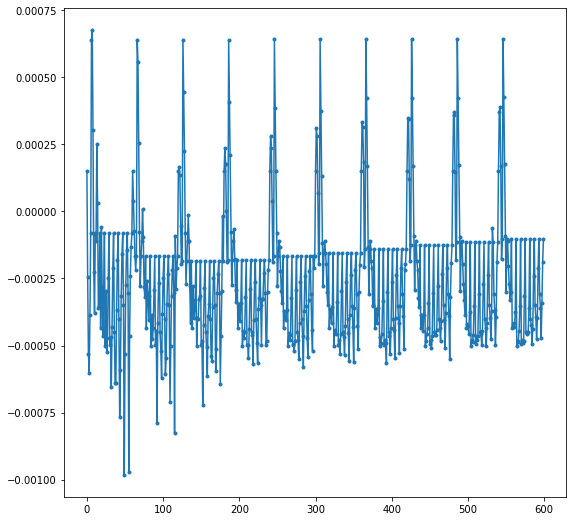

In [15]:
plt.figure(figsize = (9,9))
plt.plot(y1_list[5],'.-')

In [43]:
print(y1_list.shape)

(11, 600)


In [29]:
import plotly.express as px
df = px.data.election()


In [30]:
pixel_size  = 0.2
bulge_list = []
disk_list = []
ratio_list = []

for i, bulge_size in enumerate(np.arange(0.1,1.1,0.1)/pixel_size):
    for j, disk_size in enumerate(np.arange(0.2,2.2,0.2)/pixel_size):
        for k,ratio in enumerate(np.arange(0.0, 1.2, 0.2)):
            bulge_list.append(bulge_size)
            disk_list.append(disk_size)
            ratio_list.append(ratio)
bulge_array = np.array(bulge_list)
disk_array = np.array(disk_list)
ratio_array = np.array(ratio_list)


In [31]:
d = dict()
f = 0
for m in range(22):
    if pqlist[m] in moment_of_interests:
        print( pqlist[m])
        
        d[str(pqlist[m])+'1'] = y1_list[f]
        d[str(pqlist[m])+'2'] = y2_list[f]
        f+=1
d['bulge_size'] = bulge_array
d['disk_size'] = disk_array
d['bulge_to_total'] = ratio_array
        

(0, 4)
(1, 3)
(3, 1)
(4, 0)
(0, 6)
(1, 5)
(2, 4)
(3, 3)
(4, 2)
(5, 1)
(6, 0)


In [32]:
df = pd.DataFrame(data = d)
pd.set_option('display.max_rows', 10)


In [33]:

df

(0, 4)1   (0, 4)2   (1, 3)1   (1, 3)2   (3, 1)1   (3, 1)2   (4, 0)1  \
0   -0.329632  0.004976 -0.009247  0.527641 -0.008017  0.527607  0.329622   
1   -0.283080  0.001899 -0.003759  0.444699 -0.002781  0.444718  0.283071   
2   -0.220833 -0.000591  0.000649  0.330576  0.001304  0.330627  0.220824   
3   -0.139537 -0.001851  0.002854  0.176689  0.003152  0.176746  0.139525   
4   -0.035276 -0.001311  0.002017 -0.026367  0.002012 -0.026333  0.035261   
..        ...       ...       ...       ...       ...       ...       ...   
595 -0.263482 -0.001114  0.001945  0.474704  0.002009  0.474704  0.263481   
596 -0.581161 -0.001391  0.002158  1.040656  0.002730  1.040654  0.581157   
597 -0.852952 -0.000843  0.000627  1.520543  0.002586  1.520548  0.852946   
598 -0.941550 -0.000300 -0.000969  1.670159  0.002147  1.670165  0.941544   
599 -0.943943 -0.000004 -0.001861  1.670089  0.001855  1.670095  0.943937   

      (4, 0)2   (0, 6)1   (0, 6)2  ...   (3, 3)2   (4, 2)1       (4, 2)2  \
0   -0.004989  0.122761 -0.001809  ... -0.467816 -0.122348 -4.926182e-03   
1   -0.001913  0.124636 -0.001252  ... -0.476954 -0.123299 -4.095854e-03   
2    0.000578  0.125625 -0.000697  ... -0.482401 -0.123174 -3.049930e-03   
3    0.001834  0.125552 -0.000240  ... -0.483038 -0.121836 -1.842611e-03   
4    0.001293  0.124249  0.000007  ... -0.477506 -0.119045 -6.531048e-04   
..        ...       ...       ...  ...       ...       ...           ...   
595  0.001118  0.043819  0.000193  ... -0.165233 -0.041233 -1.891490e-04   
596  0.001392  0.098873  0.000237  ... -0.371820 -0.093170 -2.852517e-04   
597  0.000837  0.150935  0.000143  ... -0.567935 -0.142312 -1.734439e-04   
598  0.000292  0.173598  0.000045  ... -0.653099 -0.163970 -1.628486e-04   
599 -0.000005  0.180611 -0.000010  ... -0.680902 -0.170724 -5.822099e-08   

      (5, 1)1   (5, 1)2   (6, 0)1   (6, 0)2  bulge_size  disk_size  \
0    0.000377 -0.226329 -0.122765  0.001799         0.5        1.0   
1   -0.000009 -0.231860 -0.124640  0.001242         0.5        1.0   
2   -0.000294 -0.235830 -0.125629  0.000690         0.5        1.0   
3   -0.000369 -0.237662 -0.125559  0.000232         0.5        1.0   
4   -0.000167 -0.236753 -0.124257 -0.000014         0.5        1.0   
..        ...       ...       ...       ...         ...        ...   
595 -0.000367 -0.081325 -0.043819 -0.000193         5.0       10.0   
596 -0.000459 -0.183032 -0.098873 -0.000245         5.0       10.0   
597 -0.000258 -0.279682 -0.150935 -0.000156         5.0       10.0   
598 -0.000032 -0.321733 -0.173598 -0.000061         5.0       10.0   
599  0.000099 -0.335278 -0.180611 -0.000006         5.0       10.0   

     bulge_to_total  
0               0.0  
1               0.2  
2               0.4  
3               0.6  
4               0.8  
..              ...  
595             0.2  
596             0.4  
597             0.6  
598             0.8  
599             1.0  

[600 rows x 25 columns]

In [34]:
fig = px.scatter_ternary(df, a="bulge_size", b="disk_size", c="bulge_to_total", color = str(pqlist[4])+'1', color_continuous_scale = 'curl')
fig.show()

In [35]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D


(0, 6)


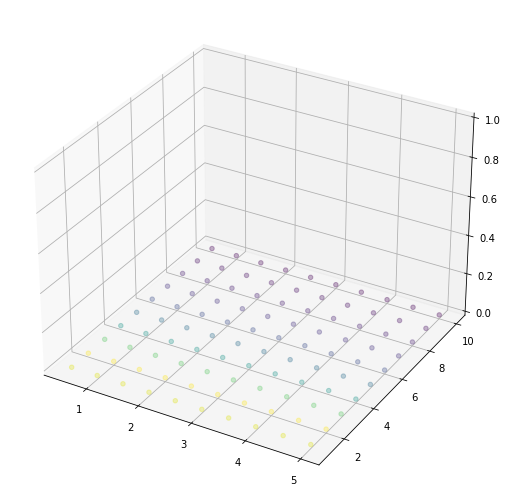

In [72]:
m = 15
print(str(pqlist[m]))


fig = plt.figure(figsize=(9,9))


ax = fig.add_subplot(111, projection='3d')

abc = ax.scatter(bulge_array[ratio_array==0.0], disk_array[ratio_array==0.0], ratio_array[ratio_array==0.0], c = d[str(pqlist[m])+'1'][ratio_array==0.0],  alpha = 0.3 )
ax.set_zlim(0, 1)
plt.grid()

#plt.colorbar()

In [37]:
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from __future__ import print_function


In [62]:
def f(x):
    clear_output()
    m = 15




    ax.scatter(bulge_array[ratio_array==x], disk_array[ratio_array==x], ratio_array[ratio_array==x], c = d[str(pqlist[m])+'1'][ratio_array==x],  alpha = 0.8 )
    plt.grid()
    #plt.show()
    


In [111]:


interp_func1_dic = {}
interp_func2_dic = {}

for i in range(11):
#     this_f1 = interpolate.LinearNDInterpolator(x, dg1[i])
#     this_f2 = interpolate.LinearNDInterpolator(x, dg2[i])

    this_f1 = interpolate.LinearNDInterpolator(squeeze_x, y1_list[i])
    this_f2 = interpolate.LinearNDInterpolator(squeeze_x, y2_list[i])
    interp_func1_dic[tuple(pq4nersc[i])] = this_f1
    interp_func2_dic[tuple(pq4nersc[i])] = this_f2

In [112]:
# def real_vs_fake(points, pq):
    

In [116]:
interp_func1_dic[(4,0)]((3,4.4,0.74))

array(0.91438668)

In [119]:
print(np.min(bulge_list),np.max(bulge_list) )
print(np.min(disk_list),np.max(disk_list) )
print(np.min(ratio_list),np.max(ratio_list) )

0.5 5.0
1.0 10.0
0.0 1.0


In [128]:
def generate_n_points(n, bulge_min = 0.5, bulge_max = 5.0, disk_min = 1.0, disk_max = 10.0, ratio_min = 0.0, ratio_max = 1.0 ):
    
    bulge_random = (bulge_max - bulge_min) * np.random.random(n) + bulge_min
    disk_random = (disk_max - disk_min) * np.random.random(n) + disk_min
    ratio_random = (ratio_max - ratio_min) * np.random.random(n) + ratio_min
    
    return np.array([bulge_random,disk_random,ratio_random  ]).T

    

In [154]:
pqlist = test0.sxm.get_pq_full(6)
pq2index = dict()
for i in range(len(pqlist)):
    pq2index[pqlist[i]] = i

In [155]:
def simulate(points,  pq):
    
    bpd_parameters_dict = dict()
    for i in range(len(points)):
        bpd_parameters_dict[i] = (points[i][0], 0.0 ,0.0,points[i][1], 0.1,0.2,points[i][2])

    index = pq2index[pq]
    print(index)

    this_m = np.zeros(shape = (25))
    this_c = np.zeros(shape = (25))
    this_c[index] += 0.002

    this_test = []

    for i in range(len(bpd_parameters_dict)):
        this_test.append(("bpd" ,1.0    ,0.0,0.0,1e-8,1e-8,"kolmogorov"  ,0.305/pixel_size,{'subtract_intersection':True, 'bpd_params':bpd_parameters_dict[i]}))

    m_moment_results = do_tests_speed(this_test,this_m, this_c,6)

    dg1 = np.array([t["abs_bias"][0] for t in m_moment_results])/0.002
    dg2 = np.array([t["abs_bias"][1] for t in m_moment_results])/0.002

    
    
    return dg1, dg2

In [156]:
def linear_interpolate(points, pq):
    dg1 = interp_func1_dic[pq](points)
    dg2 = interp_func2_dic[pq](points)
    return dg1, dg2

In [176]:
hundred_points = generate_n_points(500)

dg1_simulate, dg2_simulate = simulate(hundred_points,  (2,4))
dg1_interpolate, dg2_interpolate = linear_interpolate(hundred_points, (2,4))

Finished 100.0%


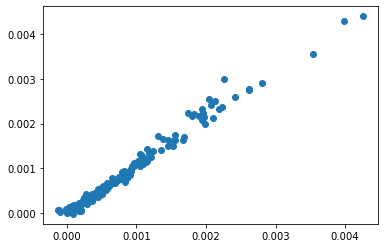

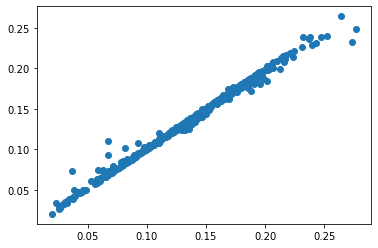

In [193]:
plt.scatter(dg1_simulate,dg1_interpolate )

In [235]:
def visualize(dg1_simulate, dg2_simulate, dg1_interpolate ,dg2_interpolate, points ):
    
    plt.figure(figsize = (6,6))
    plt.scatter(dg1_simulate,dg1_interpolate )
    plt.plot([np.min(dg1_simulate),np.max(dg1_simulate) ],[np.min(dg1_simulate),np.max(dg1_simulate)], color = 'black')
    plt.xlabel('Simulated dg1')
    plt.ylabel('Interpolated dg1')
    plt.show()
    
    plt.figure(figsize = (6,6))
    plt.scatter(dg2_simulate,dg2_interpolate )
    plt.plot([np.min(dg2_simulate),np.max(dg2_simulate) ],[np.min(dg2_simulate),np.max(dg2_simulate)], color = 'black')

    plt.xlabel('Simulated dg2')
    plt.ylabel('Interpolated dg2')
    plt.show()
    
    
    
    
    ratio1_difference = (dg1_interpolate - dg1_simulate )/dg1_simulate
    ratio2_difference = (dg2_interpolate - dg2_simulate )/dg2_simulate
    
    plt.figure(figsize = (8,6))
    plt.hist(ratio1_difference, bins = 100, range = (-1,1), histtype = 'step', label='g1')
    plt.hist(ratio2_difference, bins = 100, range = (-1,1), histtype = 'step', label='g2')

    #plt.yscale('log')
    plt.xlabel('(interpolate - simulate)/simulate')
    plt.ylabel('counts')
    plt.xlim([-1,1])
    plt.legend()
    plt.show()
    
    

    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(hundred_points[:,0][np.abs(ratio1_difference)>0.1], hundred_points[:,1][np.abs(ratio1_difference)>0.1], hundred_points[:,2][np.abs(ratio1_difference)>0.1], c = ratio1_difference[np.abs(ratio1_difference)>0.1],  alpha = 0.3 )
    ax.set_xlabel('Bulge Size (pixels)')
    ax.set_ylabel('Disk Size (pixels)')
    ax.set_zlabel('Bulge to Total Ratio')
    ax.set_zlim(0, 1)
    plt.grid()
    plt.show()


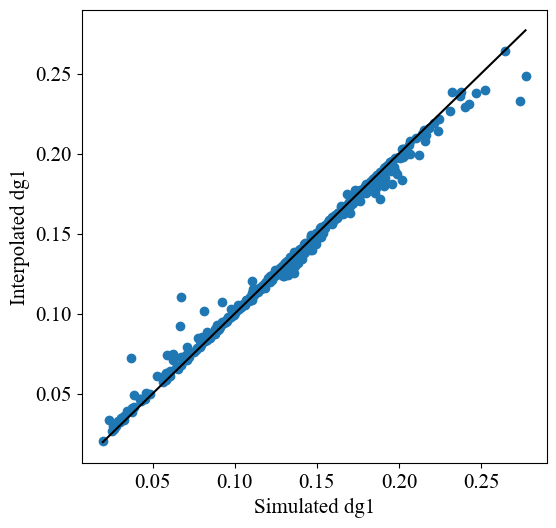

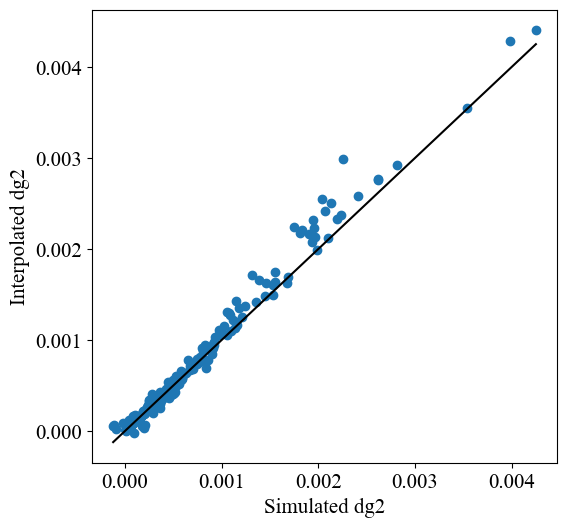

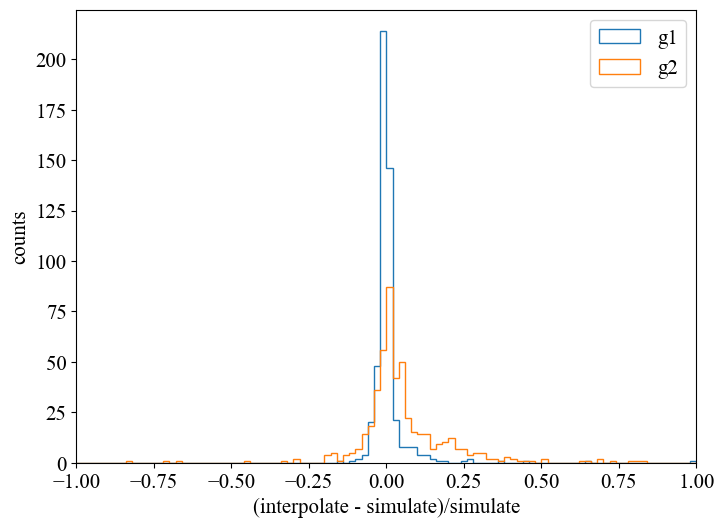

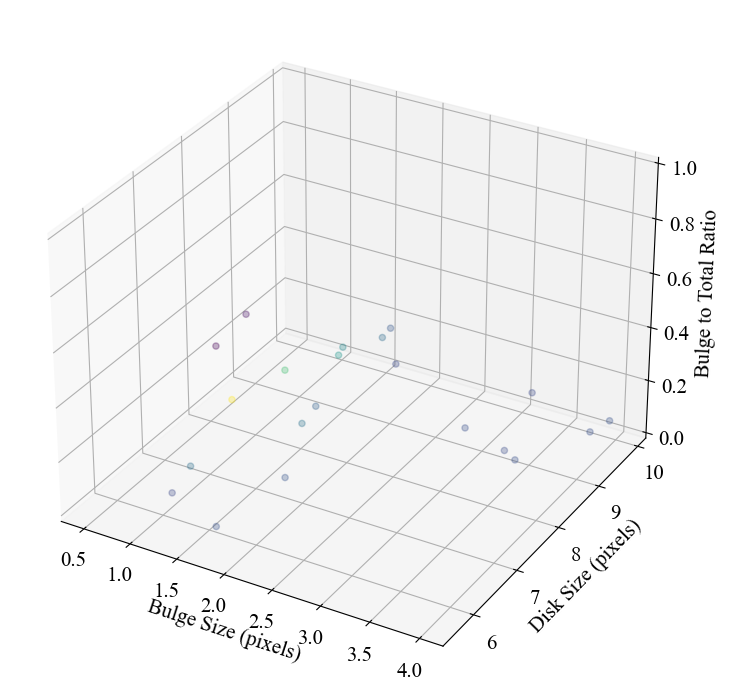

In [236]:
visualize(dg1_simulate, dg2_simulate, dg1_interpolate ,dg2_interpolate, hundred_points )

In [ ]:
plt

(3, 2)


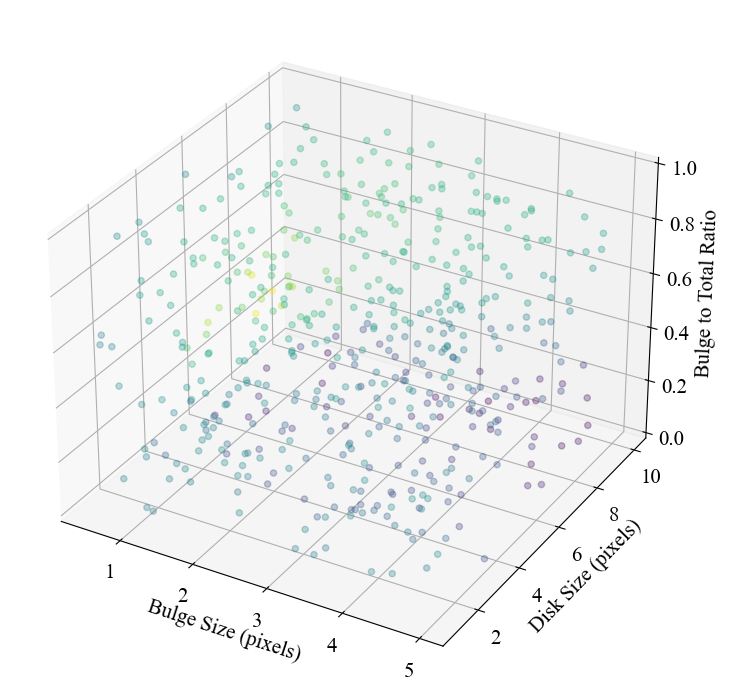

In [220]:
m = 15
print(str(pqlist[m]))


fig = plt.figure(figsize=(9,9))


ax = fig.add_subplot(111, projection='3d')

ax.scatter(hundred_points[:,0], hundred_points[:,1], hundred_points[:,2], c = dg1_simulate,  alpha = 0.3 )
ax.set_xlabel('Bulge Size (pixels)')
ax.set_ylabel('Disk Size (pixels)')
ax.set_zlabel('Bulge to Total Ratio')



ax.set_zlim(0, 1)
plt.grid()

#plt.colorbar()

In [238]:
maps_random_pick = np.load('data/maps_random_pick.npy')
print(maps_random_pick.shape)

(11, 435)


In [240]:
reduce_pq = [(4,0),(0,4),(6,0),(4,2),(2,4),(0,6),(3,1),(1,3),(5,1),(3,3),(1,5)]

points_435 = generate_n_points(435)

y1_simulate_list = []
y2_simulate_list = []

y1_interpolate_list = []
y2_interpolate_list = []

for i in range(len(reduce_pq)):
    print(i)
    this_pq = reduce_pq[i]
    this_y1_simulate, this_y2_simulate = simulate(points_435, this_pq)
    this_y1_interpolate, this_y2_interpolate = linear_interpolate(points_435, this_pq)
    
    y1_simulate_list.append(this_y1_simulate)
    y2_simulate_list.append(this_y2_simulate)
    
    y1_interpolate_list.append(this_y1_interpolate)
    y2_interpolate_list.append(this_y2_interpolate)


    

Finished 100.0%


In [241]:
y1_simulate_list = np.array(y1_simulate_list)
y2_simulate_list = np.array(y2_simulate_list)
y1_interpolate_list = np.array(y1_interpolate_list)
y2_interpolate_list = np.array(y2_interpolate_list)

In [243]:
print(y1_simulate_list.shape, maps_random_pick.shape)

(11, 435) (11, 435)


In [244]:
simulate_dg1 = y1_simulate_list* maps_random_pick
simulate_dg2 = y2_simulate_list* maps_random_pick

interpolate_dg1 = y1_interpolate_list* maps_random_pick
interpolate_dg2 = y2_interpolate_list* maps_random_pick




In [249]:
per_sample_simulate_dg1 = np.sum(simulate_dg1, axis = 0)
per_sample_simulate_dg2 = np.sum(simulate_dg2, axis = 0)

per_sample_interpolate_dg1 = np.sum(interpolate_dg1, axis = 0)
per_sample_interpolate_dg2 = np.sum(interpolate_dg2, axis = 0)

per_sample_difference_g1 = (per_sample_interpolate_dg1 - per_sample_simulate_dg1)
per_sample_difference_g2 = (per_sample_interpolate_dg2 - per_sample_simulate_dg2)


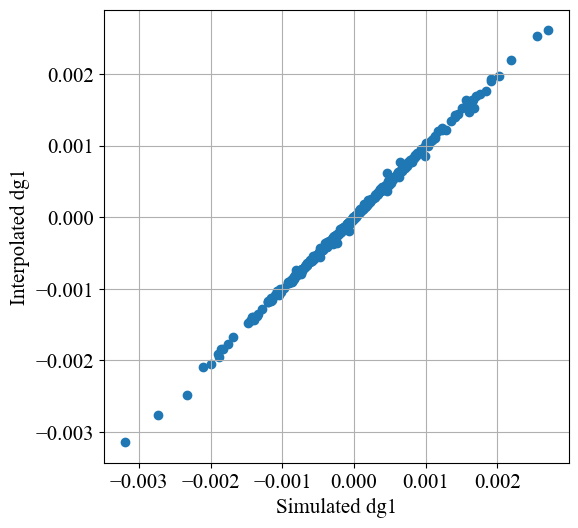

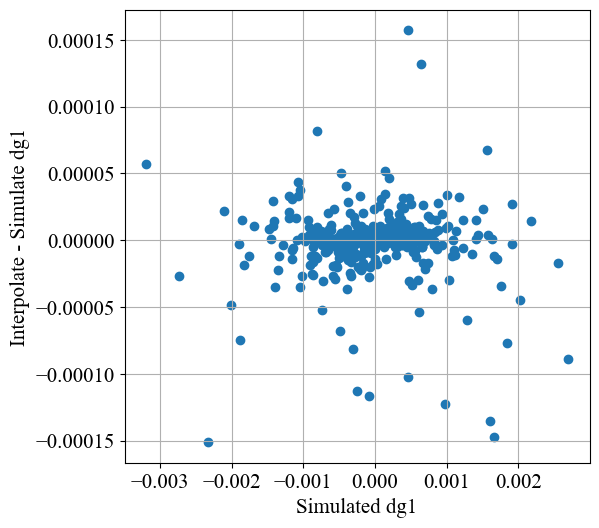

In [251]:
plt.figure(figsize = (6,6))
plt.scatter(per_sample_simulate_dg1, per_sample_interpolate_dg1 )
plt.xlabel('Simulated dg1')
plt.ylabel('Interpolated dg1')
plt.grid()
plt.show()

plt.figure(figsize = (6,6))
plt.scatter(per_sample_simulate_dg1, per_sample_difference_g1 )
plt.xlabel('Simulated dg1')
plt.ylabel('Interpolate - Simulate dg1')
plt.grid()
plt.show()


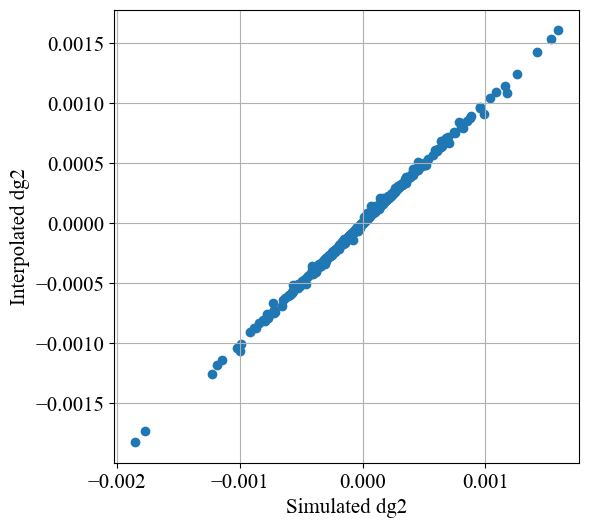

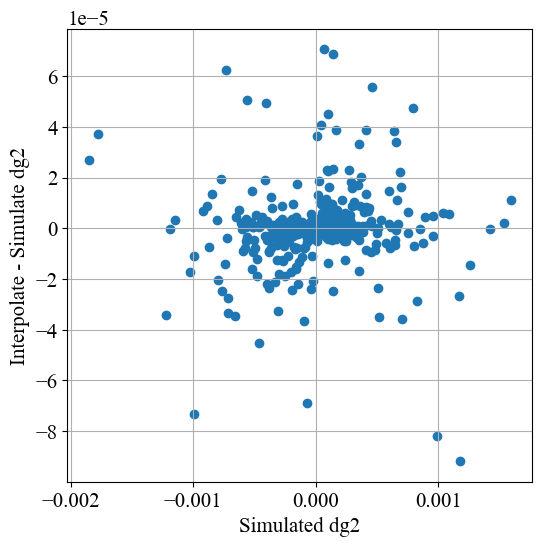

In [252]:
plt.figure(figsize = (6,6))
plt.scatter(per_sample_simulate_dg2, per_sample_interpolate_dg2 )
plt.xlabel('Simulated dg2')
plt.ylabel('Interpolated dg2')
plt.grid()
plt.show()

plt.figure(figsize = (6,6))
plt.scatter(per_sample_simulate_dg2, per_sample_difference_g2 )
plt.xlabel('Simulated dg2')
plt.ylabel('Interpolate - Simulate dg2')
plt.grid()
plt.show()
